In [78]:
import pandas as pd
import datetime
import pickle
from collections import namedtuple

from scipy.sparse import hstack
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge

import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
tqdm.pandas()

from scipy.stats import spearmanr, kendalltau


Data = namedtuple('Data', ['players', 'tournaments', 'results'])

In [2]:
def read_data() -> Data:
    def read_pkl_as_df(pkl):
        with open(pkl, 'rb') as f:
            x = pd.DataFrame(pickle.load(f)).T
            x.index = x.id
            x.drop(['id'] , axis = 1, inplace=True)
            return x
    t = read_pkl_as_df('tournaments.pkl')    
    t = t[pd.to_datetime(t.dateStart).map(lambda x: x.year) >= 2019]
    with open('results.pkl', 'rb') as f:
        r = pd.Series(pickle.load(f))
        r = r[r.index.isin(t.index)]
    ## избавимся от лишних строчек
    r = r[r.map(lambda x: len(x) > 0)]
    t = t[t.index.isin(r.index)]
    return Data(
        read_pkl_as_df('players.pkl'),
        t,
        r,
    )

In [3]:
data = read_data()

In [4]:
data.players.iloc[0]

name           Алексей
patronymic        None
surname       Абабилов
Name: 1, dtype: object

In [5]:
data.tournaments.iloc[0]

name                        Синхрон северных стран. Зимний выпуск
dateStart                               2019-01-05T19:00:00+03:00
dateEnd                                 2019-01-09T19:00:00+03:00
type                                 {'id': 3, 'name': 'Синхрон'}
season                                                /seasons/52
orgcommittee    [{'id': 28379, 'name': 'Константин', 'patronym...
synchData       {'dateRequestsAllowedTo': '2019-01-09T23:59:59...
questionQty                           {'1': 12, '2': 12, '3': 12}
Name: 4772, dtype: object

In [6]:
data.tournaments.type.map(lambda x: x['id']).value_counts()

3    463
2    300
8     94
5     12
6      7
Name: type, dtype: int64

In [7]:
data.results.iloc[0][5]

{'team': {'id': 47075,
  'name': 'Оператор Дамблдора',
  'town': {'id': 201, 'name': 'Москва'}},
 'mask': '111111101011111101101101011001011010',
 'current': {'name': 'Humlesnurroperatoren',
  'town': {'id': 201, 'name': 'Москва'}},
 'questionsTotal': 25,
 'synchRequest': {'id': 55460, 'venue': {'id': 3117, 'name': 'Москва'}},
 'position': 5.5,
 'controversials': [],
 'flags': [],
 'teamMembers': [{'flag': 'Л',
   'usedRating': 11993,
   'rating': 11993,
   'player': {'id': 38458,
    'name': 'Екатерина',
    'patronymic': 'Владимировна',
    'surname': 'Лобкова'}},
  {'flag': 'Л',
   'usedRating': 9962,
   'rating': 11954,
   'player': {'id': 5990,
    'name': 'Андрей',
    'patronymic': 'Александрович',
    'surname': 'Волыхов'}},
  {'flag': 'Л',
   'usedRating': 7109,
   'rating': 10663,
   'player': {'id': 56000,
    'name': 'Евгений',
    'patronymic': 'Николаевич',
    'surname': 'Коватенков'}},
  {'flag': 'Л',
   'usedRating': 4979,
   'rating': 9958,
   'player': {'id': 97091,


Судя по тому, как выглядят данные, то особой информации в таблице с игроками нет(фио и так упомянаются в результатах). С другой стороны и в самой таблице со списком игр особого смысла нет, за исключением, возможно даты турнира и формата его проведения... \
Сначала попробуем совсем простую модель без учёта формата

Какие могут быть идеи...  С одной стороны у игроков есть рейтинг(который мы придумали), эти игроки отвечают на вопросы(которые могут быть разной сложности - ещё одна переменная, которую нужно оценить). А потом непонятно как исходя из набора участников в команде, команда выбирает отвечающего, который даёт ответ. Человек, который будет отвечать выбирается капитаном, причём сами игроки в процессе обсуждения помогают друг другу. Отсюда можно сделать вывод, что ответ команды в первую очередь зависит от рейтинга участников, входящих в неё, сложностью вопроса, зависит от того, кто капитан.

Ещё раз вернёмся к тому, как оценивается сложность вопроса. Рейтинг "команды" зависит от рейтинга игроков. Чем выше рейтинг команды, тем на более сложный вопрос команда может дать правильный ответ. Соответственно мы можем оценить сложность вопроса исходя из того, как него отвечали команды, каждая имеет свой рейтинг. И исходя из сложности вопроса мы можем оценить рейтинг команды. Звучит как что-то похожее на какой-то итеративный алгоритм.

## Baseline

А может быть и другая идея. Отталкиваясь от подсказок, что можно сделать. Обучим логистическую регрессию, где в качестве целевой переменной будет ответ i игрока на k вопрос. Тогда в качестве признаков можно использовать как раз рейтинг игрока и сложность вопроса. Получится комбинация sigma(ax + by = {0, 1}). Долго думал, откуда взять рейтинг и сложность, вот что придумал. \
\
Пусть у нас теперь в качестве признака не сам рейтинг игрока, а его "номер", равно как и для вопроса будем использовать не сложность, а "номер". Соотвественно воспользуемся OneHotEncoding для векторизации и обучим sparse матрицу. Тогда назовём рейтингов веса перед игроками, а сложностью вопроса веса перед вопросами.\
\
Если про саму модель - хочется, чтобы была какая-то регуляризация с одной стороны(будет меньше переобучения), а с другой стороны в модели есть параметр bias - нужен ли он нам большой вопрос - не понимаю его физический смысл. Кажется, что модель можно обучить и без смещения?..

In [8]:
res = []
question_number = 0
def fill_res(l: list, q):
    def preprocess(game):
        nonlocal q
        max_mask_len = 0
        for team_perfomance in game:
            try:
                mask = team_perfomance['mask']
                max_mask_len = max(max_mask_len, len(mask))
                for member in team_perfomance['teamMembers']:
                    player_id = int(member['player']['id'])
                    for idx, question in enumerate(range(q, q + len(mask))):
                        l.append([player_id, question, int(mask[idx])])
            except Exception:
                pass
        q += max_mask_len
    return preprocess

train_games = data.tournaments[pd.to_datetime(data.tournaments.dateStart).map(lambda x: x.year) == 2019].index
train_results = data.results[data.results.index.isin(train_games)]
train_results.map(fill_res(res, question_number))
len(res)

17625847

In [9]:
player_encoder = LabelBinarizer(sparse_output = True)
player_matrix = player_encoder.fit_transform([x[0] for x in res])
question_encoder = LabelBinarizer(sparse_output = True)
question_matrix = question_encoder.fit_transform([x[1] for x in res])

player_matrix.shape, question_matrix.shape

((17625847, 57411), (17625847, 31723))

In [10]:
X_train = hstack([player_matrix, question_matrix])
y_train = np.array([x[2] for x in res])

X_train.shape

(17625847, 89134)

In [11]:
%%time
lr = LogisticRegression(
    C = 0.1, 
    fit_intercept = True,
    random_state = 57, 
    solver = 'saga',
    n_jobs = -1
)
lr.fit(X_train, y_train)

CPU times: user 2min 44s, sys: 215 ms, total: 2min 45s
Wall time: 2min 45s


LogisticRegression(C=0.1, n_jobs=-1, random_state=57, solver='saga')

In [12]:
len(lr.coef_[0])

89134

<AxesSubplot:ylabel='Density'>

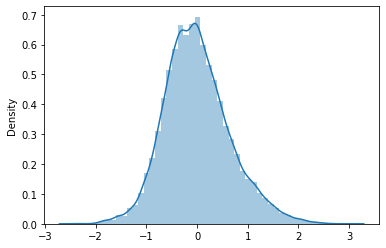

In [13]:
import seaborn as sns
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

sns.distplot(lr.coef_[0][:player_matrix.shape[1]])

<AxesSubplot:ylabel='Density'>

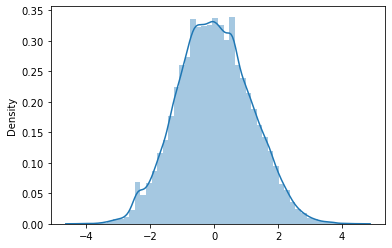

In [14]:
 sns.distplot(lr.coef_[0][player_matrix.shape[1]:])

Первые веса модели - это и есть рейтинг игроков, как видно по картинке, он распределён нормально, что вписывается в наши априорные представления о том, как может быть устроен рейтинг по типу Эло.

# 3

Как теперь составить ранжирующую модель? Можно взять линейную комбинацию рейтингов(обучить). Однако какую функцию ошибки брать? В общем с одной стороны веса в линейной комбинации должны быть одинаковыми для всех турниров, а вот участиники на этих турнирах отличаются. Соотвественно можно поступить, как и в примере выше, обучив модель с явным принаком, что команда выступала на i турнире. \
Целевой переменной хочется взять нечто, что будет соотвествовать ранжированию - это может быть позиция в рейтинге,
это может быть число ответов, решённых командой:
* обучая ранжирование(например, ту же самую позицию в зачёте можно оценить как некий квантиль в который попадёт команда на турнире) мы с одной стороны сразу оптимизируем целевую метрику, однако используя линейную модель мы предполагаем, что разница между позициями линейная и т.д. что может быть не самой лучшей идеей
* обучая ранжирование с нелинейным преобразованием позиций - какой-нибудь сигмоидой - т.е. мы увеличиваем ценность победы и проигрыша - можно тоже попробовать
* а можно предсказывать число баллов(а именно долю ответов), что дала команда и снова получить какой-то результат... 

Все эти модели используются очень легко - для ранжирования участников турнира мы будем пользоваться лишь линейной комбинацией коэффициентов участников.

Чтобы результат был детерминирован, отсортируем участников внутри команды по их рейтингу.

In [61]:
train_results

4772    [{'team': {'id': 45556, 'name': 'Рабочее назва...
4973    [{'team': {'id': 45556, 'name': 'Рабочее назва...
4974    [{'team': {'id': 2865, 'name': 'Немчиновка', '...
4975    [{'team': {'id': 4174, 'name': 'Центровые', 't...
4986    [{'team': {'id': 69309, 'name': 'Брют', 'town'...
                              ...                        
6183    [{'team': {'id': 641, 'name': 'Братья', 'town'...
6191    [{'team': {'id': 245, 'name': 'Айастан', 'town...
6249    [{'team': {'id': 61251, 'name': 'Большой проиг...
6254    [{'team': {'id': 72363, 'name': 'Дайте бланк',...
6255    [{'team': {'id': 7864, 'name': 'Одушевлённые а...
Length: 680, dtype: object

In [64]:
from tqdm.notebook import tqdm
tqdm.pandas()


## подготовим трейн - все вышеперечиленные модели отличаются лишь целевой переменной
def player_rating(player):
    pid = int(player['player']['id'])
    pid = player_encoder.transform([pid]).toarray()[0].argmax()
    return coefs[0][pid]


res = []
game_number = 0
def fill_res(l: list, g):
    def preprocess(game):
        nonlocal g
        max_mask_len = 0
        for team_perfomance in game:
            try:
                mask = team_perfomance['mask']
                position = team_perfomance['position']
                l.append([
                    g, 
                    sum([1 if x == '1' else 0 for x in mask]),
                    position,
                    sorted([player_rating(x) for x in team_perfomance['teamMembers']], reverse=True)
                ])
            except Exception:
                pass
        g += 1
    return preprocess

train_results.progress_map(fill_res(res, game_number))
len(res)

  0%|          | 0/680 [00:00<?, ?it/s]

104

In [16]:
game_encoder = LabelBinarizer(sparse_output = True)
game_matrix = game_encoder.fit_transform([x[0] for x in res])
game_matrix.shape

(86499, 675)

In [17]:
pd.DataFrame(res)[3].map(lambda x: len(x)).describe()

count    86499.000000
mean         5.222985
std          1.323040
min          0.000000
25%          5.000000
50%          6.000000
75%          6.000000
max         21.000000
Name: 3, dtype: float64

In [18]:
player_scores = pd.DataFrame([x[3] for x in res])
player_scores = player_scores[player_scores.columns[:6]]
##remove fillna
# zero_padding
# player_scores.fillna(method='ffill', axis = 1, inplace=True)
player_scores.fillna(0., inplace=True)
player_scores

,0,1,2,3,4,5
0,2.627536,2.603676,2.533872,2.486790,2.469826,2.244983
1,2.454286,1.601633,1.542157,1.494029,1.457775,0.000000
2,1.739644,1.728265,1.717789,1.713961,1.644602,1.079000
3,1.397966,1.322849,1.305878,1.239683,1.193366,0.000000
4,2.414574,1.957796,1.957068,1.883296,1.774283,1.709041
...,...,...,...,...,...,...
86494,-1.546901,-1.622664,-1.622668,0.000000,0.000000,0.000000
86495,-1.232782,-1.232786,-1.232787,0.000000,0.000000,0.000000
86496,0.303293,0.303293,0.303293,0.303293,0.303293,-0.060582
86497,0.303293,0.303293,0.303293,0.303293,0.303293,-0.060582


In [19]:
questions = pd.DataFrame([[x[0], x[1]] for x in res], columns = ['game', 'score'])
questions = questions.groupby('game').max()
questions.head()

,score
game,
0,28
1,32
2,35
3,29
4,33


In [20]:
#модель с суммой баллов
def transform_y(x):
    num = x[1]
    game = x[0]
    try:
        return num / questions.loc[game][0]
    except Exception:
        print(num, game)
    

X_train = hstack([player_scores, game_matrix]).toarray()
y_train = pd.Series(([transform_y(x) for x in res]))
X_train = X_train[~y_train.isna()]
y_train = y_train[~y_train.isna()]

X_train.shape, y_train.shape

((86460, 681), (86460,))

In [21]:
%%time
from sklearn.linear_model import Ridge
ridge_score = Ridge(
    fit_intercept = True,
    random_state = 57, 
    solver = 'saga',
)
ridge_score.fit(X_train, y_train)

CPU times: user 45.8 s, sys: 32 ms, total: 45.9 s
Wall time: 45.9 s


Ridge(random_state=57, solver='saga')

In [22]:
coefs = ridge_score.coef_[:6]
# coefs[coefs < 0] = 0
coefs

array([0.07009088, 0.08193269, 0.04777149, 0.0301645 , 0.02619377,
       0.02698569])

В целом тут видно, что чем выше рейтинг, тем больший вклад вносит игрок

In [23]:
test_games = data.tournaments[pd.to_datetime(data.tournaments.dateStart).map(lambda x: x.year) == 2020].index
test_results = data.results[data.results.index.isin(test_games)]

In [24]:
def get_team_rating(r):
    while len(r) < 6:
        r.append(r[-1])
    return sum([coefs[idx]*val for idx, val in enumerate(r)])


res = []
game_number = 0
def fill_res(l: list, g):
    def preprocess(game):
        nonlocal g
        for team_perfomance in game:
            try:
                position = team_perfomance['position']
                raitings = sorted([player_rating(x) for x in team_perfomance['teamMembers']], reverse=True)
                team_rating = get_team_rating(raitings)
                l.append([
                    g,
                    position,
                    team_rating
                ])
            except Exception:
                pass
        g += 1
    return preprocess

test_results.progress_map(fill_res(res, game_number))
len(res)

  0%|          | 0/196 [00:00<?, ?it/s]

21711

In [25]:
res = pd.DataFrame(res, columns = ['game', 'position', 'team_rating'])
res.head()

,game,position,team_rating
0,0,1.0,0.839246
1,0,2.0,0.604108
2,0,3.0,0.560113
3,0,4.0,0.674317
4,0,5.5,0.672997


In [26]:
from scipy.stats import spearmanr, kendalltau
def sp_corr(df):
    return -spearmanr(df.position, df.team_rating)[0] 
def ken_corr(df):
    return -kendalltau(df.position, df.team_rating)[0]


res.groupby('game').apply(sp_corr).mean(), res.groupby('game').apply(ken_corr).mean()

(0.7435252150804705, 0.5891459257768152)

# EM алгоритм

В baseline модели  мы делали предположение о том, что все игроки команды умеют отвечать на вопрос либо не умеют. Хотя на самом деле можно предположить, что если команда не ответила на вопрос, то скорее всего никто не смог догадаться. А если ответила, то это прежде всего результат командных обсуждений. \
В третьей части задания можно было составит рейтинг команды. Кажется, что если мы введём веса, которые получились в результате линейной регрессии как вес в правильный ответ, то качество рейтинга должно улучшиться. \
Соотвественно на первом этапе мы считаем, что у нас ответы всех членов команды были равновероятны, а на втором этапе мы должны получить вероятность того, что i игрок команды дал какую-то часть ответа, что помогла команде.
вклад игрока в рейтинг это coef[team_rank] * user_score / team_score... Соотвественно это будет весом примера?... \
надо сделать так, чтобы сумма этих весов осталась такой же, какая и была при обучении

## E-шаг

In [27]:
team_perfomance = test_results.iloc[42][5]
team_perfomance.keys()

dict_keys(['team', 'mask', 'current', 'questionsTotal', 'synchRequest', 'position', 'controversials', 'flags', 'teamMembers'])

In [28]:
raitings = [player_rating(x) for x in team_perfomance['teamMembers']]
team_rating = get_team_rating(sorted(raitings, reverse = True))

In [29]:
raitings, team_rating, coefs

([0.2764005947836974,
  0.5546212943142731,
  0.2347511730355313,
  0.49899751693611055,
  0.5181117248221903,
  0.993206257369655],
 0.1684341894251463,
 array([0.07009088, 0.08193269, 0.04777149, 0.0301645 , 0.02619377,
        0.02698569]))

In [30]:
coefs

array([0.07009088, 0.08193269, 0.04777149, 0.0301645 , 0.02619377,
       0.02698569])

In [31]:
a = pd.Series(raitings).reset_index()
a.columns = ['idx', 'usr_rating'] 
a.sort_values(by = 'usr_rating', inplace=True, ascending=False)
a['usr_impact1'] = a.usr_rating.values*coefs[:a.shape[0]]

a['usr_impact2'] = a['usr_impact1'] - a.usr_impact1.mean()
a['usr_impact3'] = a['usr_impact2'] / a.usr_impact2.std()
a['usr_impact4'] = np.exp(a['usr_impact3'])
a['usr_impact5'] = a['usr_impact4'] / a['usr_impact4'].mean()
a

,idx,usr_rating,usr_impact1,usr_impact2,usr_impact3,usr_impact4,usr_impact5
5,5,0.993206,0.069615,0.041542,1.664486,5.282957,3.298407
1,1,0.554621,0.045442,0.017369,0.695938,2.005589,1.252187
4,4,0.518112,0.024751,-0.003321,-0.133079,0.875396,0.546552
3,3,0.498998,0.015052,-0.013020,-0.521689,0.593517,0.370562
0,0,0.276401,0.007240,-0.020832,-0.834696,0.434006,0.270971
2,2,0.234751,0.006335,-0.021737,-0.870959,0.418550,0.261321


In [32]:
def e_step_version_1(c):
    pass

Получилось вроде правдоподобно. Или нет. И где тут ожидание...

С одной стороны вроде бы я получил какие-то коэффициенты... А с другой стороны тут нет никаких вероятностных рассуждений, т.е. это не может быть EM алгоритмом. Придумаем что-то другое, а в конце сравним результаты

# E step
version 2 \
Изменим концепцию. На самом деле при первой итерации алгоритма мы считали вероятность правильного ответа каждого человека, где метка совпадает с ответом его команды. Понятно, что в команде не все могут решить такую задачу. \
С одной стороны, если команда не решила задачу, то значит, никто не может её решить.
Введём скрытую переменную - это вероятность того, что именно этот человек споcобен решить задачу. Если он решает задачу, то тогда получается, что и команда решила её. Т.е. вероятность того, что команда с этим человеком решила задачу равна произведению вероятности того, что человек решил задачу и команда решила задачу. Вероятность, что команда решила задачу можно оценить снизу как 1 - вероятность того, что никто не может решить задачу. И скорее всего там будет какой-то коеффициент, например, он зависит от числа участников в команде(сделаем его гиперпараметром)

In [70]:
def prepare_train():
    res = []
    question_number = 0
    def fill_res(l: list, q):
        def preprocess(game):
            nonlocal q
            max_mask_len = 0
            for team_perfomance in game:
                try:
                    mask = team_perfomance['mask']
                    max_mask_len = max(max_mask_len, len(mask))
                    team = team_perfomance['team']['id']
                    for member in team_perfomance['teamMembers']:
                        player_id = int(member['player']['id'])
                        for idx, question in enumerate(range(q, q + len(mask))):
                            l.append([player_id, question, team, int(mask[idx])])
                except Exception:
                    pass
            q += max_mask_len
        return preprocess
    
    train_results.progress_map(fill_res(res, question_number))
    player_encoder = LabelBinarizer(sparse_output = True)
    player_matrix = player_encoder.fit_transform([x[0] for x in res])
    question_encoder = LabelBinarizer(sparse_output = True)
    question_matrix = question_encoder.fit_transform([x[1] for x in res])
    res = pd.DataFrame(res)
    res.columns = ['player', 'question', 'team', 'answer']
    X_train = hstack([player_matrix, question_matrix])
    return X_train, res, player_encoder

In [33]:
def e_step(res, probas):
    if probas is None:
        probas = np.ones(res.shape[0])
    res['not_solved'] = 1 - res.answer * probas
    not_solved = res.groupby(['question', 'team']).not_solved.agg.('prod', 'count').reset_index()
    not_solved.columns = ['question', 'team', 'team_not_solved', 'team_size']
    res = res.merge(not_solved, on = ['question', 'team'], how='left')
    res['weights'] = 1 - res['team_not_solved']
    res.weights[res.weights == 0] = 1
    return res.answer, res.weights

In [41]:
def m_step(X_train, y_train, weights):
    lr = LogisticRegression(
        C = 0.1, 
        fit_intercept = True,
        random_state = 57, 
        solver = 'saga',
        n_jobs = 12
    )
    lr.fit(X_train, y_train, weights)
    probas = lr.predict_proba(X_train)[:, 1]
    return lr.coef_, probas

In [82]:
def get_team_coefs(coefs):
    def player_rating(player):
        pid = int(player['player']['id'])
        pid = player_encoder.transform([pid]).toarray()[0].argmax()
        return coefs[0][pid]

    res = []
    game_number = 0
    def fill_res(l: list, g):
        def preprocess(game):
            nonlocal g
            max_mask_len = 0
            for team_perfomance in game:
                try:
                    mask = team_perfomance['mask']
                    position = team_perfomance['position']
                    l.append([
                        g, 
                        sum([1 if x == '1' else 0 for x in mask]),
                        position,
                        sorted([player_rating(x) for x in team_perfomance['teamMembers']], reverse=True)
                    ])
                except Exception:
                    pass
            g += 1
        return preprocess

    train_results.progress_map(fill_res(res, game_number))
    game_encoder = LabelBinarizer(sparse_output = True)
    game_matrix = game_encoder.fit_transform([x[0] for x in res])
    player_scores = pd.DataFrame([x[3] for x in res])
    player_scores = player_scores[player_scores.columns[:6]]
    player_scores.fillna(0., inplace=True)
    
    questions = pd.DataFrame([[x[0], x[1]] for x in res], columns = ['game', 'score'])
    questions = questions.groupby('game').max()
    
    def transform_y(x):
        num = x[1]
        game = x[0]
        try:
            return num / questions.loc[game][0]
        except Exception:
            print(num, game)
    
    X_train = hstack([player_scores, game_matrix]).toarray()
    y_train = pd.Series(([transform_y(x) for x in res]))
    X_train = X_train[~y_train.isna()]
    y_train = y_train[~y_train.isna()]
    
    ridge_score = Ridge(
        fit_intercept = True,
        random_state = 57, 
        solver = 'saga',
    )
    ridge_score.fit(X_train, y_train)  
    return ridge_score.coef_[:6]
    
    
def score(team_coefs, coefs):
    def player_rating(player):
        pid = int(player['player']['id'])
        pid = player_encoder.transform([pid]).toarray()[0].argmax()
        return coefs[0][pid]
    
    test_games = data.tournaments[pd.to_datetime(data.tournaments.dateStart).map(lambda x: x.year) == 2020].index
    test_results = data.results[data.results.index.isin(test_games)]
    
    def get_team_rating(r):
        while len(r) < 6:
            r.append(r[-1])
        return sum([team_coefs[idx]*val for idx, val in enumerate(r)])

    res = []
    game_number = 0
    def fill_res(l: list, g):
        def preprocess(game):
            nonlocal g
            for team_perfomance in game:
                try:
                    position = team_perfomance['position']
                    raitings = sorted([player_rating(x) for x in team_perfomance['teamMembers']], reverse=True)
                    team_rating = get_team_rating(raitings)
                    l.append([
                        g,
                        position,
                        team_rating
                    ])
                except Exception:
                    pass
            g += 1
        return preprocess

    test_results.progress_map(fill_res(res, game_number))
    
    
    res = pd.DataFrame(res, columns = ['game', 'position', 'team_rating'])
    
    def sp_corr(df):
        return -spearmanr(df.position, df.team_rating)[0] 
    def ken_corr(df):
        return -kendalltau(df.position, df.team_rating)[0]

    print(res.groupby('game').apply(sp_corr).mean(), res.groupby('game').apply(ken_corr).mean())

In [72]:
train_games = data.tournaments[pd.to_datetime(data.tournaments.dateStart).map(lambda x: x.year) == 2019].index
train_results = data.results[data.results.index.isin(train_games)]
X_train, res, player_encoder = prepare_train()

  0%|          | 0/680 [00:00<?, ?it/s]

In [42]:
y_train, weights = e_step(res, None)

<ipython-input-33-3dd178877d87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.weights[res.weights == 0] = 1


In [43]:
coefs, probas = m_step(X_train, y_train, weights)

In [76]:
team_coefs = get_team_coefs(coefs)
team_coefs

  0%|          | 0/680 [00:00<?, ?it/s]

      score
game       
0        28
1        32
2        35
3        29
4        33


<ipython-input-75-55604fd783c9>:43: RuntimeWarning: invalid value encountered in long_scalars
  return num / questions.loc[game][0]


array([0.07009088, 0.08193269, 0.04777149, 0.0301645 , 0.02619377,
       0.02698569])

In [79]:
score(team_coefs, coefs)

  0%|          | 0/196 [00:00<?, ?it/s]

(21711, 3)
0.7435252150804705 0.5891459257768152


In [83]:
probas = None
for i in range(5):
    y_train, weights = e_step(res, probas)
    coefs, probas = m_step(X_train, y_train, weights)
    team_coefs = get_team_coefs(coefs)
    print(f'iter {i}')
    print(team_coefs)
    score(team_coefs, coefs)

  0%|          | 0/680 [00:00<?, ?it/s]

iter 0
[0.07009088 0.08193269 0.04777149 0.0301645  0.02619377 0.02698569]


  0%|          | 0/196 [00:00<?, ?it/s]

0.7435252150804705 0.5891459257768152


  0%|          | 0/680 [00:00<?, ?it/s]

iter 1
[0.06494297 0.07506459 0.04372278 0.02759217 0.0240138  0.02532843]


  0%|          | 0/196 [00:00<?, ?it/s]

0.7429897334807612 0.587442002042765


  0%|          | 0/680 [00:00<?, ?it/s]

iter 2
[0.06407992 0.0732317  0.04325796 0.02709992 0.02355564 0.02496682]


  0%|          | 0/196 [00:00<?, ?it/s]

0.7428613455221236 0.5867693035539561


  0%|          | 0/680 [00:00<?, ?it/s]

iter 3
[0.06389129 0.07274624 0.04322072 0.02698124 0.02344834 0.02485845]


  0%|          | 0/196 [00:00<?, ?it/s]

0.7427772101679139 0.5862967559840496


  0%|          | 0/680 [00:00<?, ?it/s]

iter 4
[0.06385282 0.07260479 0.04323877 0.02694615 0.02342027 0.0248211 ]


  0%|          | 0/196 [00:00<?, ?it/s]

0.7425046359740879 0.5861217887387936


Может быть не стоит менять коэффициенты?

In [85]:
probas = None
for i in range(10):
    y_train, weights = e_step(res, probas)
    coefs, probas = m_step(X_train, y_train, weights)
    if i == 0:
        team_coefs = get_team_coefs(coefs)
    print(f'iter {i}')
    score(team_coefs, coefs)

  0%|          | 0/680 [00:00<?, ?it/s]

iter 0


  0%|          | 0/196 [00:00<?, ?it/s]

0.7435252150804705 0.5891459257768152
iter 1


  0%|          | 0/196 [00:00<?, ?it/s]

0.7429025264664615 0.5872749880024015
iter 2


  0%|          | 0/196 [00:00<?, ?it/s]

0.7433823321350949 0.5871272115615332
iter 3


  0%|          | 0/196 [00:00<?, ?it/s]

0.7428300878686855 0.5863895111777645
iter 4


  0%|          | 0/196 [00:00<?, ?it/s]

0.7424720970751318 0.5861001146938322
iter 5


  0%|          | 0/196 [00:00<?, ?it/s]

0.7424527214653612 0.5860821557896863
iter 6


  0%|          | 0/196 [00:00<?, ?it/s]

0.7424637436931922 0.5860892673159565
iter 7


  0%|          | 0/196 [00:00<?, ?it/s]

0.7424074317131315 0.5860280313315993
iter 8


  0%|          | 0/196 [00:00<?, ?it/s]

0.7423961586956498 0.5860257372600133
iter 9


  0%|          | 0/196 [00:00<?, ?it/s]

0.7423948827799141 0.5860242603650807


Попробуем с суммой, которая кажется более логичной.

In [87]:
probas = None
for i in range(10):
    y_train, weights = e_step(res, probas)
    coefs, probas = m_step(X_train, y_train, weights)
    if i == 0:
        team_coefs = np.array([6 - i for i in range(6)])
    print(f'iter {i}')
    score(team_coefs, coefs)

iter 0


  0%|          | 0/196 [00:00<?, ?it/s]

0.7449423499082848 0.590253574215968
iter 1


  0%|          | 0/196 [00:00<?, ?it/s]

0.7446525329101448 0.5894937754967559
iter 2


  0%|          | 0/196 [00:00<?, ?it/s]

0.7444439047668893 0.5885863742558204
iter 3


  0%|          | 0/196 [00:00<?, ?it/s]

0.745034811154258 0.5890431703529624
iter 4


  0%|          | 0/196 [00:00<?, ?it/s]

0.7453742783230034 0.5892824569256413
iter 5


  0%|          | 0/196 [00:00<?, ?it/s]

0.7453751578286664 0.589280754295243
iter 6


  0%|          | 0/196 [00:00<?, ?it/s]

0.7453451616710737 0.5892514401419874
iter 7


  0%|          | 0/196 [00:00<?, ?it/s]

0.7451905554182918 0.5891543536267689
iter 8


  0%|          | 0/196 [00:00<?, ?it/s]

0.7452569926504168 0.5892144987576514
iter 9


  0%|          | 0/196 [00:00<?, ?it/s]

0.745257101530387 0.589212193390809


вроде немного улучшилось

In [88]:
probas = None
for i in range(10):
    y_train, weights = e_step(res, probas)
    coefs, probas = m_step(X_train, y_train, weights)
    if i == 0:
        team_coefs = np.zeros(6)
        team_coefs[0] = 1
    print(f'iter {i}')
    score(team_coefs, coefs)

iter 0


  0%|          | 0/196 [00:00<?, ?it/s]

0.7341883577183127 0.5793363925553946
iter 1


  0%|          | 0/196 [00:00<?, ?it/s]

0.7324081045430173 0.5773653919943106
iter 2


  0%|          | 0/196 [00:00<?, ?it/s]

0.7309920493736068 0.5760161243860827


KeyboardInterrupt: 

In [89]:
probas = None
for i in range(10):
    y_train, weights = e_step(res, probas)
    coefs, probas = m_step(X_train, y_train, weights)
    if i == 0:
        team_coefs = np.ones(6)
    print(f'iter {i}')
    score(team_coefs, coefs)

iter 0


  0%|          | 0/196 [00:00<?, ?it/s]

0.733735218469532 0.5791631556355058
iter 1


  0%|          | 0/196 [00:00<?, ?it/s]

0.7338419040683601 0.579068385112379
iter 2


  0%|          | 0/196 [00:00<?, ?it/s]

0.7344131497316464 0.5791370063472853
iter 3


  0%|          | 0/196 [00:00<?, ?it/s]

0.7337652041268392 0.5783003168991953
iter 4


  0%|          | 0/196 [00:00<?, ?it/s]

0.7336682375858926 0.5782289386961721
iter 5


  0%|          | 0/196 [00:00<?, ?it/s]

0.7336752116454867 0.5782655009376922
iter 6


  0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: 

В итоге лучше всего сработала сумма, где наибольший вес у самого высокого по рейтингу игрока. Есть ли какой-то прок от ЕМ - не ясно.